In [1]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

import pickle

https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=CAD&limit=500

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist = hist[['high', 'low', 'open', 'volumefrom', 'volumeto', 'close']]
target_col = 'close'
print(hist.shape)
hist.head(10)

(501, 6)


,high,low,open,volumefrom,volumeto,close
time,,,,,,
2019-08-05,15494.1,14476.7,14479.2,172.01,2613805.76,15227.1
2019-08-06,15944.9,14652.9,15227.1,84.65,1297525.18,15053.8
2019-08-07,15815.0,14750.2,15053.8,88.46,1362814.79,15776.7
2019-08-08,15824.0,15222.5,15776.7,68.75,1070396.00,15800.0
2019-08-09,15889.0,15450.0,15800.0,30.12,470903.46,15700.5
2019-08-10,15800.0,14869.3,15700.5,45.07,688885.31,14955.2
2019-08-11,15300.0,14754.5,14955.2,25.92,390620.03,15255.3
2019-08-12,15255.3,14951.2,15255.3,36.50,550740.63,15041.1
2019-08-13,15174.3,14211.5,15041.1,56.37,826959.10,14442.9


In [3]:
def train_test_split(df, test_size=0.2):
  split_row = len(df) - int(test_size * len(df))
  train_data = df.iloc[:split_row]
  test_data = df.iloc[split_row:]
  return train_data, test_data

train, test = train_test_split(hist, test_size=0.2)
# got train size 401 points, test size 100 points
train.shape, test.shape

((401, 6), (100, 6))

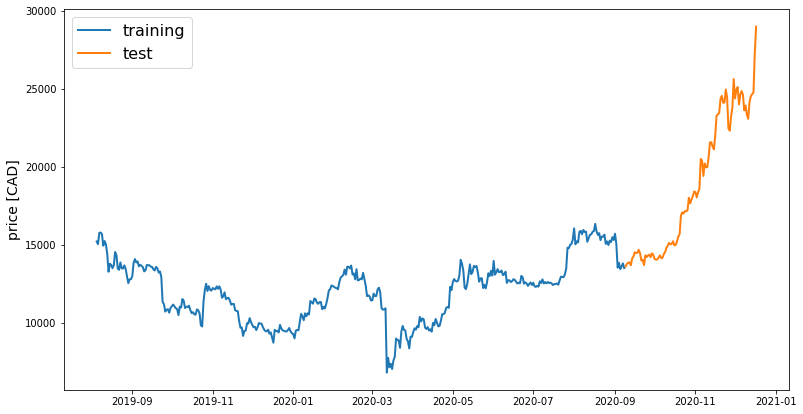

In [4]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

line_plot(train[target_col], test[target_col], 'training', 'test', title='')

Include pre_horizon value to shift the prediction forward from the sliding window. Thus shift the targets forward and the data shift by the value of pred_horizon.

In [83]:
def normalise_zero_base(df):
  # print(df.info())
  # print(df.head())
  return df / df.iloc[0] - 1

def normalise_min_max(df):
  return (df - df.min()) / (data.max() - df.min())

def extract_window_data(df, window_len=5, zero_base=True):
  window_data = []
  dates = []
  # extract window_len points for win segment
  for idx in range(len(df) - window_len):
      tmp = df[idx: (idx + window_len)].copy()
      # print(tmp)
      if zero_base:
          tmp = normalise_zero_base(tmp)
      dates.append(tmp.index)
      window_data.append(tmp.values)
  return np.array(window_data), dates

def prepare_data(df, target_col, window_len=10, pred_horizon=5, zero_base=True, test_size=0.2):
  # split data
  train_data, test_data = train_test_split(df, test_size=test_size)

  # process data get tensors by win
  X_train, train_dates = extract_window_data(train_data, window_len, zero_base)
  X_test, test_dates = extract_window_data(test_data, window_len, zero_base)
  
  # extract targets - the point after each win_len segment + offset of predict_horizon
  y_train = train_data[target_col][window_len + pred_horizon:]
  y_test = test_data[target_col][window_len + pred_horizon:]

  # make offset by value of horizon
  X_train = X_train[:-pred_horizon]
  X_test = X_test[:-pred_horizon]
  train_dates = train_dates[:-pred_horizon]
  test_dates = test_dates[:-pred_horizon]
  train_data = train_data[:-pred_horizon]
  test_data = test_data[:-pred_horizon]
  
  for i in range(20):
    print()
    print('test dates: ', test_dates[-i])
    print('ytest: ', y_test[-i:-i+1])
  
  y_trian = y_train.values
  y_test = y_test.values

  if zero_base:
      y_train = y_train / train_data[target_col][:-window_len].values - 1
      y_test = y_test / test_data[target_col][:-window_len].values - 1

  return train_data, test_data, X_train, X_test, y_train, y_test, train_dates, test_dates

def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
  model = Sequential()
  model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))

  model.compile(loss=loss, optimizer=optimizer)
  return model

def save_model(model, file_name):
    """
    Save model in pickle format
    :param model: training model
    :param file_name: String
        Path to the model file
    """
    with open(file_name, 'wb') as file:
        pickle.dump(model, file)
        
def load_model(file_name):
    """
    Load model from file
    :param file_name: String
        Path to the model file
    :return: predictive model
    """
    with open(file_name, 'rb') as file:
        return pickle.load(file)

In [102]:
np.random.seed(42)
window_len = 5
pred_horizon = 6
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [103]:
train, test, X_train, X_test, y_train, y_test, train_dates, test_dates = prepare_data(hist, target_col, 
                                                                                      window_len=window_len, 
                                                                                      pred_horizon=pred_horizon,
                                                                                      zero_base=zero_base, 
                                                                                      test_size=test_size)


test dates:  DatetimeIndex(['2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12',
               '2020-09-13'],
              dtype='datetime64[ns]', name='time', freq=None)
ytest:  time
2020-09-20    14466.74
Name: close, dtype: float64

test dates:  DatetimeIndex(['2020-12-06', '2020-12-07', '2020-12-08', '2020-12-09',
               '2020-12-10'],
              dtype='datetime64[ns]', name='time', freq=None)
ytest:  Series([], Name: close, dtype: float64)

test dates:  DatetimeIndex(['2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09'],
              dtype='datetime64[ns]', name='time', freq=None)
ytest:  time
2020-12-16    27337.58
Name: close, dtype: float64

test dates:  DatetimeIndex(['2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07',
               '2020-12-08'],
              dtype='datetime64[ns]', name='time', freq=None)
ytest:  time
2020-12-15    24778.67
Name: close, dtype: float64

test dates:  DatetimeIndex(['2020-12-03', '2020-12-

In [104]:
# check shapes
test[:10], test.shape, X_test.shape, len(test_dates), y_test.shape, \
train[:10], train.shape, X_train.shape, len(train_dates), y_train.shape

(                high       low      open  volumefrom    volumeto     close
 time                                                                      
 2020-09-09  13794.39  13307.82  13519.09       90.67  1230573.81  13619.53
 2020-09-10  13936.68  13613.69  13619.53      113.55  1561850.95  13785.72
 2020-09-11  13892.18  13595.79  13785.72       80.58  1106903.43  13862.71
 2020-09-12  13924.01  13695.21  13862.71       63.03   871896.56  13888.15
 2020-09-13  14019.70  13581.53  13888.15       59.32   817713.93  13702.47
 2020-09-14  14236.60  13634.76  13702.47       94.01  1313114.00  14136.14
 2020-09-15  14555.73  14047.86  14136.14      111.56  1588627.23  14264.24
 2020-09-16  14714.82  14130.08  14264.24       92.63  1338766.74  14537.22
 2020-09-17  14748.14  14279.34  14537.22       89.04  1285660.70  14480.11
 2020-09-18  14583.59  14377.31  14480.11       75.44  1092181.45  14513.64,
 (94, 6),
 (89, 5, 6),
 89,
 (89,),
                high      low     open  volumefrom 

In [105]:
model = build_lstm_model( X_train, output_size=1, 
                         neurons=lstm_neurons, 
                         dropout=dropout, 
                         loss=loss, 
                         optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, 
                    batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 1s 4ms/step - loss: 0.0170
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 5/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0113
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 13/20
13/13 [==============================

In [106]:
# save in h5
# save_model(model, 'model_v1_lstm400.pkl')
model.save('model_v1_lstm400_mod_win.h5')

In [107]:
# load from h5
# model = load_model(model, 'model_v1_lstm400.pkl')
model.load_weights('model_v1_lstm400_mod_win.h5')

# make inference
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.06646275870393475

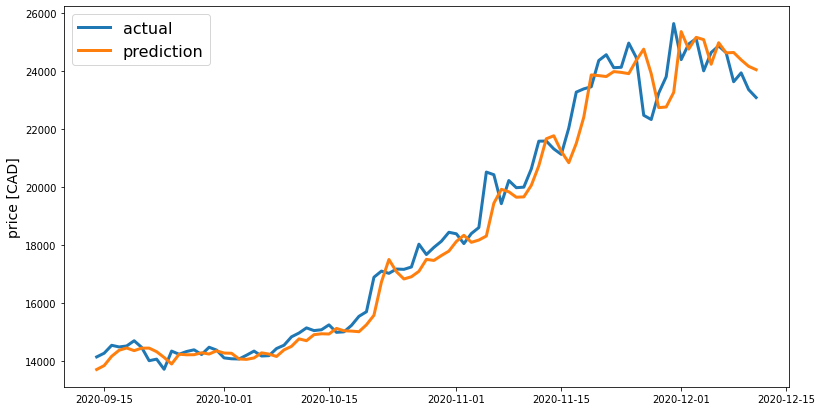

In [108]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)